In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('YouTube_EDA').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/21 19:55:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Canada

In [39]:
df = spark.read.csv('CA_youtube_trending_data_clean.csv', inferSchema = True, header = True)
df.printSchema()

[Stage 98:===========================================>              (3 + 1) / 4]

root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publishedAt: timestamp (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- trending_date: timestamp (nullable = true)
 |-- tags: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- _c15: string (nullable = true)



In [40]:
# get rid of last empty column that spark inferschema made
df = df.drop("_c15")
df.show(5)

+-----------+--------------------+-------------------+--------------------+--------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+
|   video_id|               title|        publishedAt|           channelId|  channelTitle|categoryId|      trending_date|                tags|view_count| likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|
+-----------+--------------------+-------------------+--------------------+--------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+
|KX06ksuS6Xo|Diljit Dosanjh: C...|2020-08-11 07:30:02|UCZRdNleCgW-BGUJf...|Diljit Dosanjh|        10|2020-08-12 00:00:00|clash diljit dosa...|   9140911|296541|    6180|        30059|https://i.ytimg.c...|            false|           false|
|J78aPJ3VyNs|I left youtube fo...|2020-0

In [41]:
import pyspark.sql.functions as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [42]:
# clean data, drop bad records
print('Rows with no views: ' + str(df.filter(df['view_count'] == 0).count()))
print('Total rows: ' + str(df.count()))

Rows with no views: 37
Total rows: 268742


In [43]:
# Filter out rows with view_count = 0
df = df.filter(F.col("view_count") != 0)
print('Updated rows: ' + str(df.count()))

[Stage 106:>                                                        (0 + 4) / 4]

Updated rows: 268705


In [46]:
df.groupBy("comments_disabled").count().show()

# Filter out rows with no comments
df = df.filter(F.col("comments_disabled") != 'true')

[Stage 109:>                                                        (0 + 4) / 4]

+-----------------+------+
|comments_disabled| count|
+-----------------+------+
|             true|  3407|
|            false|265298|
+-----------------+------+



Total videos: 265298
Distinct video IDs: 50215


+-----------+-----+
|   video_id|count|
+-----------+-----+
|LH0CWJYgEaI|   16|
|k1BneeJTDcU|   15|
|P6xdRuI6TNc|   14|
|Ta4VBDPWbSc|   14|
|BC19kwABFwc|   14|
|AhSl7uRrObw|   14|
|8BHPnGm9cNo|   14|
|Df_hrHHcQ_g|   14|
|jbsV6RGCPyg|   14|
|Ecy1FBdCRbQ|   14|
+-----------+-----+
only showing top 10 rows



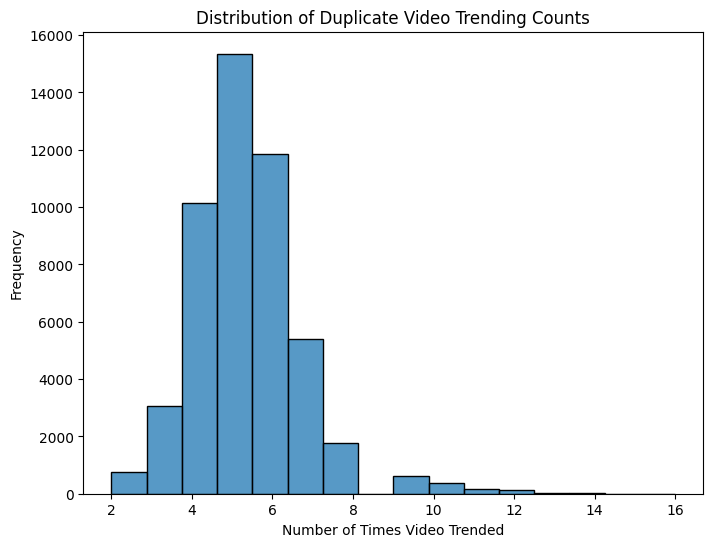

In [47]:
# eda for video ids, getting videos that trended most often too 
# Count total rows and distinct video IDs
total_videos = df.count()
distinct_videos = df.select("video_id").distinct().count()
print("Total videos:", total_videos)
print("Distinct video IDs:", distinct_videos)

# find video_ids that occur more than once (duplicate entries)
duplicates = df.groupBy("video_id").count().filter("count > 1").orderBy("count", ascending = False)
duplicates.show(10)

duplicates_pd = duplicates.toPandas()

plt.figure(figsize=(8,6))
sns.histplot(duplicates_pd['count'], bins=16)
plt.title("Distribution of Duplicate Video Trending Counts")
plt.xlabel("Number of Times Video Trended")
plt.ylabel("Frequency")
plt.show()

+------------------------------------------------------------+------------+----------+
|title                                                       |title_length|word_count|
+------------------------------------------------------------+------------+----------+
|Diljit Dosanjh: CLASH (Official) Music Video | G.O.A.T.     |55          |8         |
|I left youtube for a month and THIS is what happened.       |53          |11        |
|Apex Legends | Stories from the Outlands – “The Endorsement”|60          |10        |
|I ASKED HER TO BE MY GIRLFRIEND...                          |34          |7         |
|Ultimate DIY Home Movie Theater for The LaBrant Family!     |55          |9         |
+------------------------------------------------------------+------------+----------+
only showing top 5 rows



+-------+-----------------+------------------+
|summary|     title_length|        word_count|
+-------+-----------------+------------------+
|  count|           265298|            265298|
|   mean|50.82048865803738| 8.936810680819304|
| stddev|20.57015725672448|3.7155747984268155|
|    min|                1|                 1|
|    max|              100|                25|
+-------+-----------------+------------------+



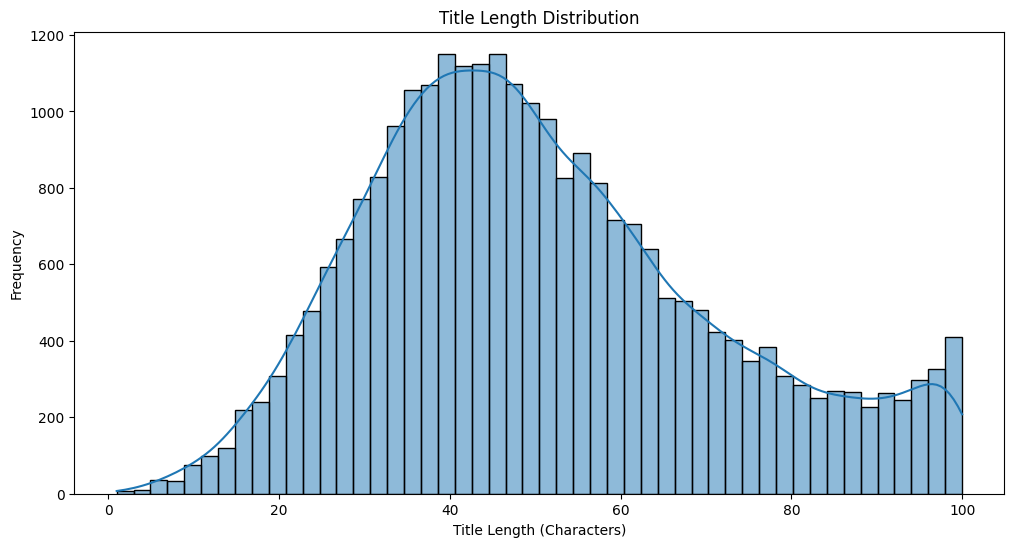

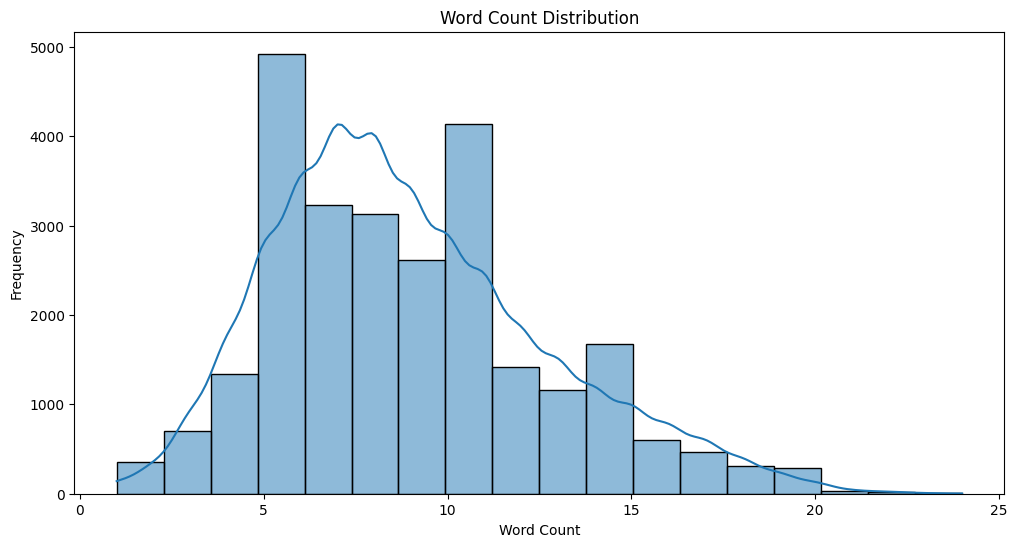

In [48]:
# adding title statistics and seeing statistics 
# Create a column for the length of each title (number of characters)
df = df.withColumn("title_length", F.length("title"))

# Create a column for the word count (splitting on whitespace)
df = df.withColumn("word_count", F.size(F.split("title", " ")))

# View sample titles with computed lengths and word counts
df.select("title", "title_length", "word_count").show(5, truncate=False)

# Get summary statistics on title length and word count
df.select("title_length", "word_count").describe().show()

# take sample
sample_titles = df.select("title_length", "word_count").sample(fraction=0.10, seed=42).toPandas()

# Plot 1: Title Length Distribution
plt.figure(figsize=(12, 6))
sns.histplot(sample_titles["title_length"], bins=50, kde=True)
plt.title("Title Length Distribution")
plt.xlabel("Title Length (Characters)")
plt.ylabel("Frequency")
plt.show()

# Plot 2: Word Count Distribution
plt.figure(figsize=(12, 6))
sns.histplot(sample_titles["word_count"], bins=18, kde=True)
plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

In [51]:
# looking at publishing and time features

# Extract year, month, and day of week from publishedAt
df = df.withColumn("publish_year", F.year("publishedAt")).withColumn("publish_month", F.month("publishedAt")).withColumn("publish_dayofweek", F.dayofweek("publishedAt")).withColumn("publish_hour", F.hour("publishedAt"))

# Show a sample of the new time-related columns
df.select("publishedAt", "publish_year", "publish_month", "publish_dayofweek", "publish_hour").show(5)

# Group by publish year to see counts per year
df.groupBy("publish_year").count().orderBy("publish_year").show()


+-------------------+------------+-------------+-----------------+------------+
|        publishedAt|publish_year|publish_month|publish_dayofweek|publish_hour|
+-------------------+------------+-------------+-----------------+------------+
|2020-08-11 07:30:02|        2020|            8|                3|           7|
|2020-08-11 16:34:06|        2020|            8|                3|          16|
|2020-08-11 17:00:10|        2020|            8|                3|          17|
|2020-08-11 19:20:14|        2020|            8|                3|          19|
|2020-08-11 15:10:05|        2020|            8|                3|          15|
+-------------------+------------+-------------+-----------------+------------+
only showing top 5 rows



[Stage 142:==========================================>              (3 + 1) / 4]

+------------+-----+
|publish_year|count|
+------------+-----+
|        2020|28103|
|        2021|73033|
|        2022|72293|
|        2023|71813|
|        2024|20056|
+------------+-----+



+-------------+-----+
|publish_month|count|
+-------------+-----+
|            1|23821|
|            2|22633|
|            3|24481|
|            4|19557|
|            5|18209|
|            6|19610|
|            7|18252|
|            8|23137|
|            9|23425|
|           10|24465|
|           11|22806|
|           12|24902|
+-------------+-----+



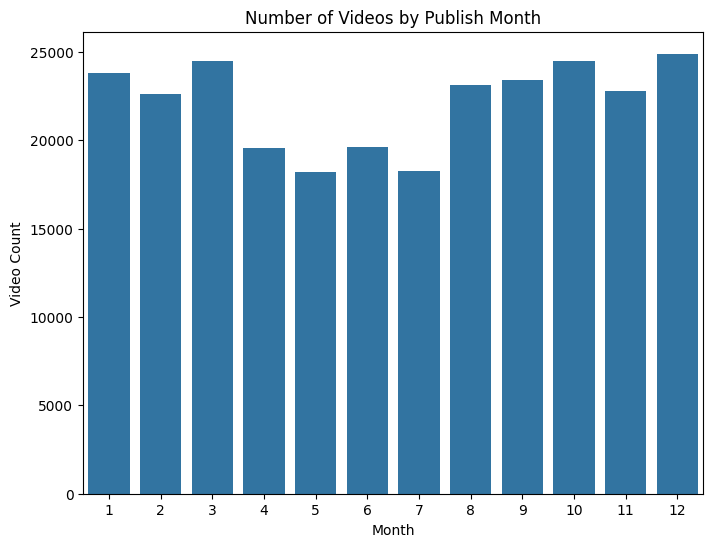

In [52]:
# Aggregate count by month of publication
monthly_counts = df.groupBy(F.month("publishedAt").alias("publish_month")).count().orderBy("publish_month")
monthly_counts.show()

# Convert to Pandas for plotting
monthly_pd = monthly_counts.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="publish_month", y="count", data=monthly_pd)
plt.title("Number of Videos by Publish Month")
plt.xlabel("Month")
plt.ylabel("Video Count")
plt.show()


+-----------+-----+
|publish_day|count|
+-----------+-----+
|          1|40622|
|          2|38417|
|          3|39531|
|          4|37751|
|          5|34476|
|          6|38951|
|          7|35550|
+-----------+-----+



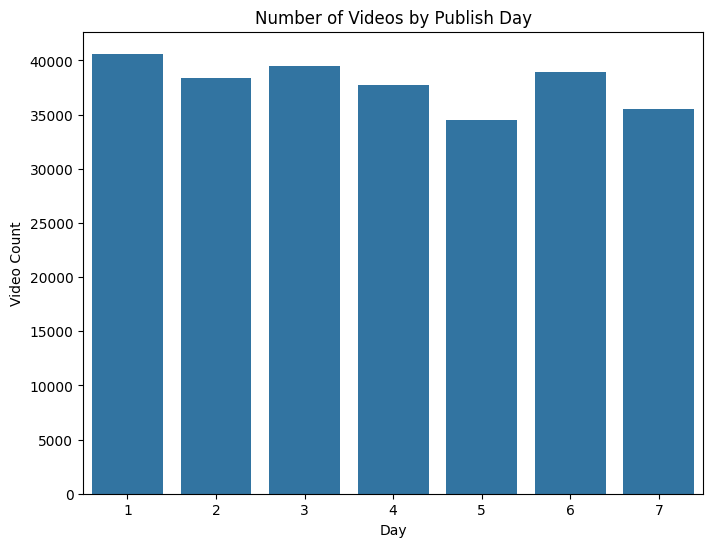

In [53]:
# Aggregate count by month of publication
weekly_counts = df.groupBy(F.dayofweek("publishedAt").alias("publish_day")).count().orderBy("publish_day")
weekly_counts.show()

# Convert to Pandas for plotting
weekly_pd = weekly_counts.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="publish_day", y="count", data=weekly_pd)
plt.title("Number of Videos by Publish Day")
plt.xlabel("Day")
plt.ylabel("Video Count")
plt.show()


+------------+-----+
|publish_hour|count|
+------------+-----+
|           0| 8122|
|           1| 6774|
|           2| 5702|
|           3| 5618|
|           4| 9991|
|           5| 5671|
|           6| 2711|
|           7| 2559|
|           8| 3574|
|           9| 5772|
|          10| 4369|
|          11| 5411|
|          12| 8645|
|          13|13169|
|          14|18012|
|          15|24144|
|          16|27161|
|          17|23547|
|          18|17076|
|          19|16395|
+------------+-----+
only showing top 20 rows



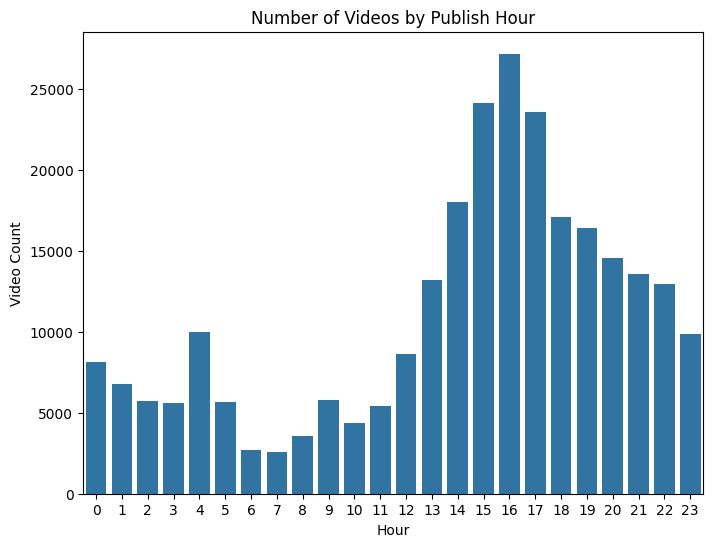

In [54]:
# Aggregate count by month of publication
hourly_counts = df.groupBy(F.hour("publishedAt").alias("publish_hour")).count().orderBy("publish_hour")
hourly_counts.show()

# Convert to Pandas for plotting
hourly_pd = hourly_counts.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="publish_hour", y="count", data=hourly_pd)
plt.title("Number of Videos by Publish Hour")
plt.xlabel("Hour")
plt.ylabel("Video Count")
plt.show()

In [55]:
# Count how many trending videos each channel has
df.groupBy("channelId", "channelTitle").count().orderBy("count", ascending=False).show(10)

[Stage 178:>                                                        (0 + 4) / 4]

+--------------------+------------------+-----+
|           channelId|      channelTitle|count|
+--------------------+------------------+-----+
|UCWJ2lWNubArHWmf3...|               NBA| 1282|
|UCaNeFN9L6CHcfn_F...|       DAZN Canada|  869|
|UCB_qr75-ydFVKSF9...|         FORMULA 1|  721|
|UCVhibwHk4WKw4leU...|         SPORTSNET|  710|
|UCX6OQ3DkcsbYNE6H...|           MrBeast|  663|
|UCRijo3ddMTht_IHy...|      Dude Perfect|  654|
|UCPD_bxCRGpmmeQcb...|    First We Feast|  615|
|UCo_IB5145EVNcf8h...|The Game Theorists|  613|
|UCqFMzb-4AUf6WAIb...|               NHL|  605|
|UCiS882YPwZt1NfaM...|    Genshin Impact|  579|
+--------------------+------------------+-----+
only showing top 10 rows



In [57]:
# mapping categoryid to its value through joining json file
categories_df = spark.read.option("multiLine", "true").json("CA_category_id.json")
categories_df = categories_df.select(F.explode("items").alias("item"))
categories_df = categories_df.select(
    F.col("item.id").alias("categoryId"),
    F.col("item.snippet.title").alias("categoryTitle")
)

# Cast categoryId to integer so it matches your main DataFrame
categories_df = categories_df.withColumn("categoryId", F.col("categoryId").cast("integer"))

# Show the categories for verification
categories_df.show(truncate=False)


+----------+--------------------+
|categoryId|categoryTitle       |
+----------+--------------------+
|1         |Film & Animation    |
|2         |Autos & Vehicles    |
|10        |Music               |
|15        |Pets & Animals      |
|17        |Sports              |
|18        |Short Movies        |
|19        |Travel & Events     |
|20        |Gaming              |
|21        |Videoblogging       |
|22        |People & Blogs      |
|23        |Comedy              |
|24        |Entertainment       |
|25        |News & Politics     |
|26        |Howto & Style       |
|27        |Education           |
|28        |Science & Technology|
|30        |Movies              |
|31        |Anime/Animation     |
|32        |Action/Adventure    |
|33        |Classics            |
+----------+--------------------+
only showing top 20 rows



+--------------------+-----+
|categoryTitle       |count|
+--------------------+-----+
|Entertainment       |56157|
|Gaming              |52216|
|Music               |34475|
|Sports              |33593|
|People & Blogs      |22960|
|Comedy              |14408|
|Film & Animation    |9497 |
|Science & Technology|8581 |
|Howto & Style       |8296 |
|Education           |7791 |
|News & Politics     |7181 |
|Autos & Vehicles    |6340 |
|Travel & Events     |2385 |
|Pets & Animals      |1315 |
|NULL                |103  |
+--------------------+-----+



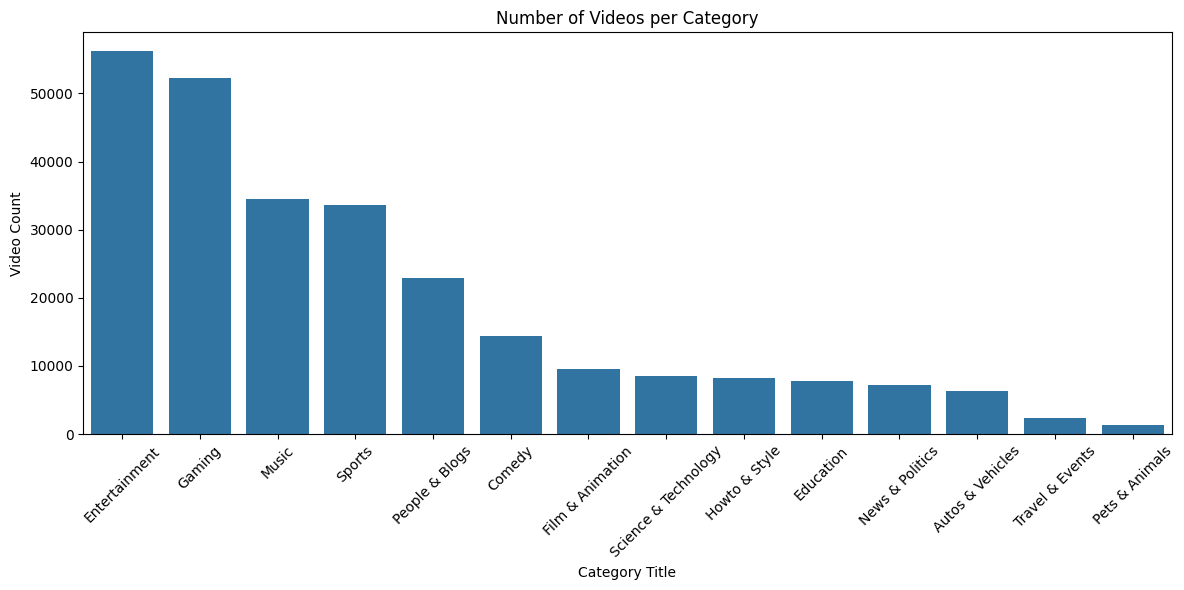

In [58]:
# Join the main DataFrame 'df' with the categories DataFrame
df_with_categories = df.join(categories_df, on="categoryId", how="left")

# Group by categoryTitle and count videos
category_counts = df_with_categories.groupBy("categoryTitle").count().orderBy("count", ascending=False)
category_counts.show(truncate=False)

# Convert to Pandas for visualization
category_counts_pd = category_counts.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x="categoryTitle", y="count", data=category_counts_pd)
plt.title("Number of Videos per Category")
plt.xlabel("Category Title")
plt.ylabel("Video Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

75th percentile of view counts: 2042799.5


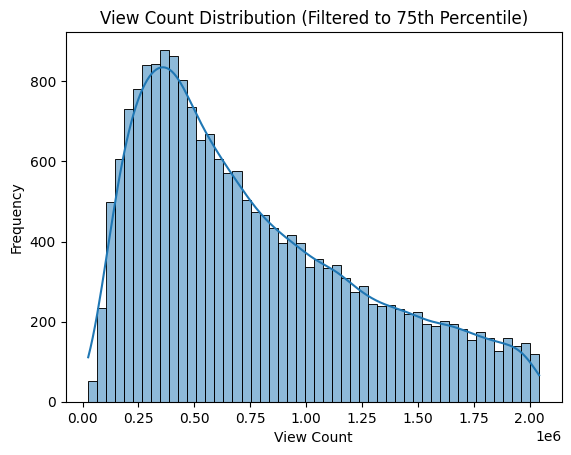

In [60]:
# Convert a sample to Pandas for a histogram
sample_views = df.select("view_count").sample(fraction=0.10, seed=42).toPandas()

# Determine a threshold: the 75th percentile of view counts
threshold = sample_views["view_count"].quantile(0.75)
print("75th percentile of view counts:", threshold)

# Filter the data to include only view counts below the threshold
filtered_sample_views = sample_views[sample_views["view_count"] <= threshold]

# Plot the histogram with the actual view count values
sns.histplot(filtered_sample_views["view_count"], bins=50, kde=True)
plt.title("View Count Distribution (Filtered to 75th Percentile)")
plt.xlabel("View Count")
plt.ylabel("Frequency")
plt.show()


+-------+------------------+
|summary|             likes|
+-------+------------------+
|  count|            265298|
|   mean|120911.67260213043|
| stddev| 360593.7894347651|
|    min|                 0|
|    max|          16021548|
+-------+------------------+

+------+----------+-----------+
| likes|view_count|likes_ratio|
+------+----------+-----------+
|296541|   9140911|       0.03|
|353797|   2038853|       0.17|
|146740|   2381688|       0.06|
|156914|   1514614|        0.1|
| 45803|   1123889|       0.04|
+------+----------+-----------+
only showing top 5 rows



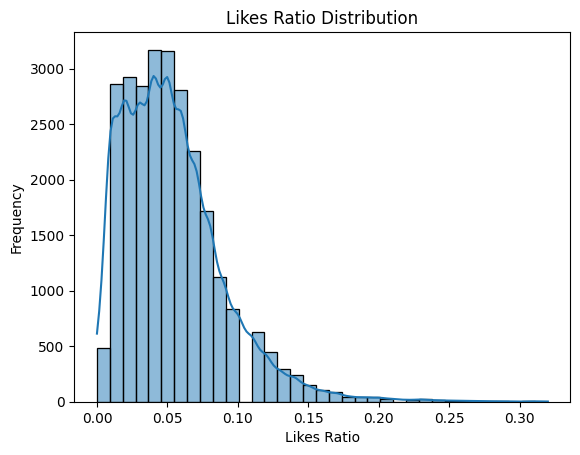

In [61]:
# Summary statistics for likes
df.select("likes").describe().show()

# Create a ratio column to see likes per view
df = df.withColumn("likes_ratio", F.round(F.col("likes") / F.col("view_count"), 2))
df.select("likes", "view_count", "likes_ratio").show(5)

# Take a 10% sample of the data for visualization
sample_likes_ratio = df.select("likes_ratio").sample(fraction=0.10, seed=42).toPandas()

# Plot the histogram for the likes_ratio distribution
sns.histplot(sample_likes_ratio["likes_ratio"], bins=35, kde=True)
plt.title("Likes Ratio Distribution")
plt.xlabel("Likes Ratio")
plt.ylabel("Frequency")
plt.show()

75th percentile of view likes: 101487.5


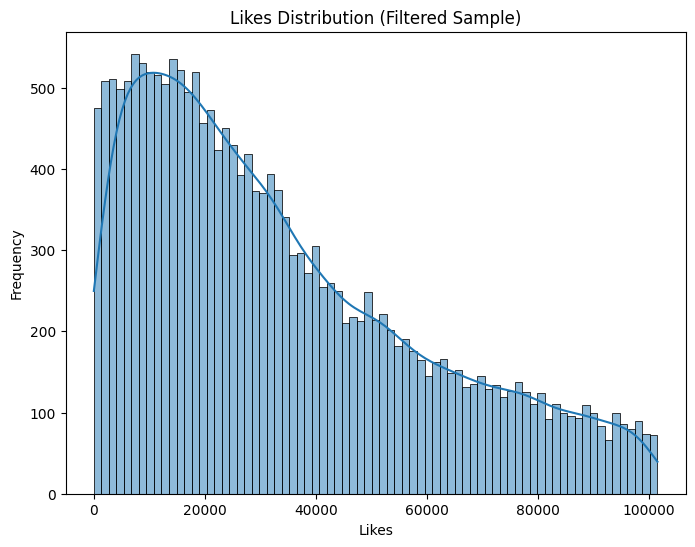

In [62]:
# Get a sample for visualization
sample_likes = df.select("likes").sample(fraction=0.10, seed=42).toPandas()

# Determine a threshold: e.g., the 75th percentile of view counts
threshold = sample_likes["likes"].quantile(0.75)
print("75th percentile of view likes:", threshold)

# Filter the data to include only view counts below the threshold
filtered_sample_likes = sample_likes[sample_likes["likes"] <= threshold]

plt.figure(figsize=(8, 6))
sns.histplot(filtered_sample_likes["likes"], bins=75, kde=True)
plt.title("Likes Distribution (Filtered Sample)")
plt.xlabel("Likes")
plt.ylabel("Frequency")
plt.show()

+-------+------------------+
|summary|          dislikes|
+-------+------------------+
|  count|            265298|
|   mean|1157.2408612202128|
| stddev| 8202.828612843732|
|    min|                 0|
|    max|            879357|
+-------+------------------+

+--------+----------+--------------+
|dislikes|view_count|dislikes_ratio|
+--------+----------+--------------+
|    6180|   9140911|   6.760814E-4|
|    2628|   2038853|    0.00128896|
|    2794|   2381688|  0.0011731176|
|    5857|   1514614|  0.0038669919|
|     964|   1123889|    8.57736E-4|
+--------+----------+--------------+
only showing top 5 rows

75th percentile of view likes: 0.000548084


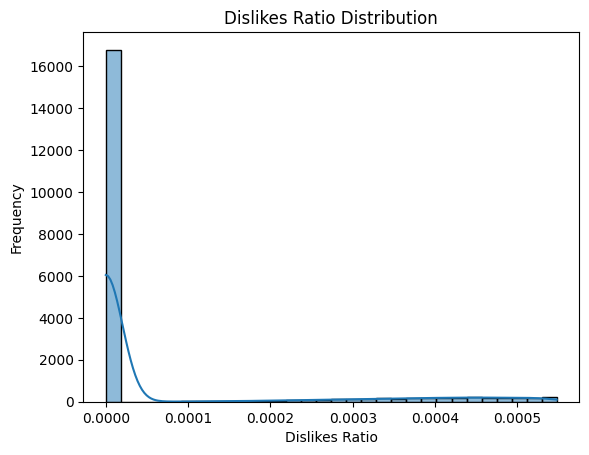

In [74]:
# Summary statistics for dislikes
df.select("dislikes").describe().show()

# Create a ratio column to see likes per view (watch out for division by zero)
df = df.withColumn("dislikes_ratio", F.round(F.col("dislikes") / F.col("view_count"), 10))
df.select("dislikes", "view_count", "dislikes_ratio").show(5)

# Take a 10% sample of the data for visualization (adjust fraction if needed)
sample_dislikes_ratio = df.select("dislikes_ratio").sample(fraction=0.10, seed=42).toPandas()

# Determine a threshold: e.g., the 75th percentile of view counts
threshold = sample_dislikes_ratio["dislikes_ratio"].quantile(0.75)
print("75th percentile of view likes:", threshold)

# Filter the data to include only view counts below the threshold
filtered_sample_dislikes_ratio = sample_dislikes_ratio[sample_dislikes_ratio["dislikes_ratio"] <= threshold]

# Plot the histogram for the likes_ratio distribution
sns.histplot(filtered_sample_dislikes_ratio["dislikes_ratio"], bins=30, kde=True)
plt.title("Dislikes Ratio Distribution")
plt.xlabel("Dislikes Ratio")
plt.ylabel("Frequency")
plt.show()


+-------+-----------------+
|summary|    comment_count|
+-------+-----------------+
|  count|           265298|
|   mean|8906.848841679923|
| stddev|66165.30130043732|
|    min|                0|
|    max|          6738536|
+-------+-----------------+

+-------------+----------+--------------------+
|comment_count|view_count|      comments_ratio|
+-------------+----------+--------------------+
|        30059|   9140911|0.003288403092427002|
|        40222|   2038853| 0.01972775869569802|
|        16549|   2381688|0.006948433212074797|
|        35331|   1514614|0.023326735392647895|
|         2198|   1123889|0.001955709149213134|
+-------------+----------+--------------------+
only showing top 5 rows



75th percentile of comments ratio: 0.004907015614202069


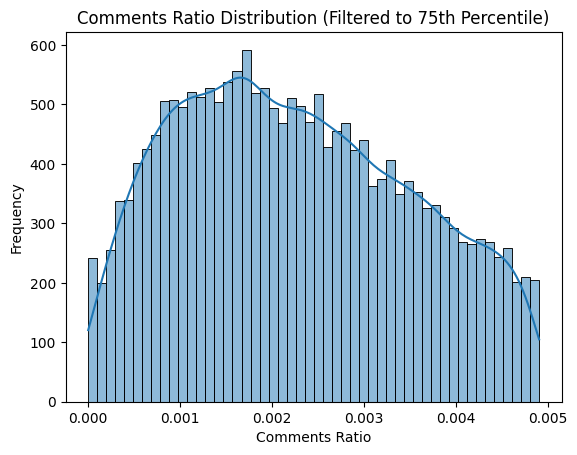

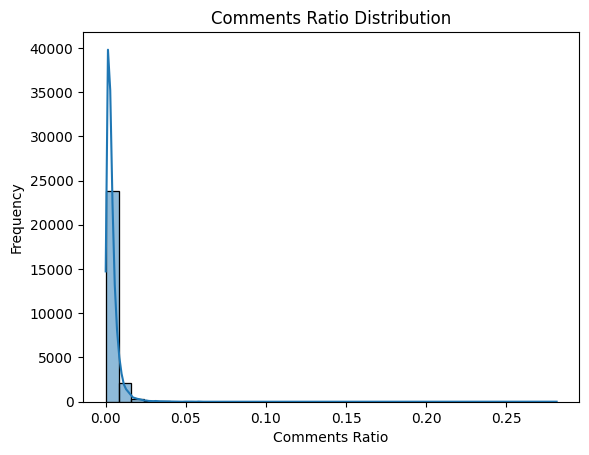

In [75]:
# Summary statistics for comment_count
df.select("comment_count").describe().show()

# Create a ratio column for comments per view
df = df.withColumn("comments_ratio", F.col("comment_count")/F.col("view_count"))
df.select("comment_count", "view_count", "comments_ratio").show(5)

# Take a 10% sample of the data for visualization (adjust fraction if needed)
sample_comments_ratio = df.select("comments_ratio").sample(fraction=0.10, seed=42).toPandas()

threshold = sample_comments_ratio["comments_ratio"].quantile(0.75)
print("75th percentile of comments ratio:", threshold)

# Filter the data to include only view counts below the threshold
filtered_comments_ratio = sample_comments_ratio[sample_comments_ratio["comments_ratio"] <= threshold]

# Plot the histogram with the actual view count values
sns.histplot(filtered_comments_ratio["comments_ratio"], bins=50, kde=True)
plt.title("Comments Ratio Distribution (Filtered to 75th Percentile)")
plt.xlabel("Comments Ratio")
plt.ylabel("Frequency")
plt.show()


# Plot the histogram for the likes_ratio distribution
sns.histplot(sample_comments_ratio["comments_ratio"], bins=35, kde=True)
plt.title("Comments Ratio Distribution")
plt.xlabel("Comments Ratio")
plt.ylabel("Frequency")
plt.show()


## Great Britain

## United States